In [1]:
!which python

/home/prat/.pyEnvs/tutorial-mlops/bin/python


In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

## Load the CSV data

In [2]:
data = pd.read_csv('data/dataset_train_test.csv', sep=';', decimal=',')

In [3]:
data.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.0,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.0,Marseille
2,NaN,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.0,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.5,Marseille
4,NaN,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,NaN,Bordeaux


## Check datatypes

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9562 entries, 0 to 9561
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Entreprise    7636 non-null   object 
 1   Metier        9562 non-null   object 
 2   Technologies  9562 non-null   object 
 3   Diplome       9562 non-null   object 
 4   Experience    8531 non-null   float64
 5   Ville         9562 non-null   object 
dtypes: float64(1), object(5)
memory usage: 448.3+ KB


## Check for the presence of NAN

In [5]:
data.isna().sum()

Entreprise      1926
Metier             0
Technologies       0
Diplome            0
Experience      1031
Ville              0
dtype: int64

<div class="alert alert-block alert-info">
    <b>Lets know more about the features before deciding what to do with the NANs..</b>
</div>

## Check Unique Values

In [6]:
data.Metier.unique()

array(['Data scientist', 'Data architecte', 'Lead data scientist',
       'Data engineer'], dtype=object)

In [7]:
data.Diplome.unique()

array(['Master', 'Phd', 'Bachelor', 'BSc', 'MSc', 'No diploma', 'PhD',
       'MASTER', 'master', 'bachelor', 'NO', 'msc', 'Mastere'],
      dtype=object)

<div class="alert alert-block alert-info">
    <b>Lets fix the duplicate values in `Diplome`..</b>
</div>

In [8]:
data.loc[data.Diplome == 'PhD', 'Diplome'] = 'Phd'
data.loc[data.Diplome == 'NO', 'Diplome'] = 'No diploma'
data.loc[data.Diplome.isin(['MASTER', 'MSc', 'Mastere', 'msc', 'master']), 'Diplome'] = 'Master'
data.loc[data.Diplome.isin(['bachelor', 'BSc']), 'Diplome'] = 'Bachelor'

In [9]:
data.Diplome.unique()

array(['Master', 'Phd', 'Bachelor', 'No diploma'], dtype=object)

In [10]:
data.Ville.unique()

array(['Paris', 'Marseille', 'Nantes', 'Bordeaux', 'Lille', 'Toulouse',
       'Rouen', 'Lyon', 'Strasbourg', 'Grenoble', 'Nice', 'Toulon',
       'Montpellier', 'Rennes'], dtype=object)

In [11]:
data.Entreprise.unique()

array(['Sanofi', 'Massachusetts General Hospital(MGH)', nan, ...,
       'Galvanize', 'Marsh', 'Ra Pharmaceutical'], dtype=object)

In [12]:
data.Entreprise.nunique()

1320

In [13]:
data.Entreprise.unique()[:20]

array(['Sanofi', 'Massachusetts General Hospital(MGH)', nan,
       'Ann & Robert H. Lurie Children’s Hospital of Chicago',
       'S&P Global Ratings', 'NVIDIA', 'Cedars-Sinai Medical Center',
       'Fibroblast', 'General Motors', 'KPMG', 'R&D Partners', 'ERPi',
       'Ball Aerospace', 'The Boston Consulting Group', 'Feeding America',
       'Natera', 'TrueMotion', 'McKinsey & Company', 'Novi Labs',
       'Ginkgo Bioworks'], dtype=object)

<div class="alert alert-block alert-info">
    <b>Looking at the values, it does not make sense that a profile might depend on the name of the company he/she is working for..</b></br>
    Atleast for a baseline model, we can eliminate this feature.</br>
</div>

## Fixing the NANs

In [14]:
# number of records where both `Entreprise` and `Experience` are NAN
data[(data.Entreprise.isna()) & (data.Experience.isna())].shape[0]

197

In [15]:
# number of records where `Experience` is NAN and `Entreprise` is not
# which implies they must have experience..
data[(~data.Entreprise.isna()) & (data.Experience.isna())].shape[0]

834

In [15]:
# total NAN in Experience is equal to the sum of the above two?
data[(~data.Entreprise.isna()) & (data.Experience.isna())].shape[0] + data[(data.Entreprise.isna()) & (data.Experience.isna())].shape[0], \
data.Experience.isna().sum()

(1031, 1031)

<div class="alert alert-block alert-info">
    <b>We can use the `Metier` to fill the NAN in experience where we know the profile if of a person currently working</b>
</div>

In [16]:
mean_exp = data.groupby('Metier')['Experience'].mean().to_dict()
mean_exp

{'Data architecte': 2.9949387320191794,
 'Data engineer': 2.963747645951036,
 'Data scientist': 2.255155387743247,
 'Lead data scientist': 3.96688132474701}

In [17]:
for k, v in mean_exp.items():
    mean_exp[k] = round(v * 2) / 2
mean_exp

{'Data architecte': 3.0,
 'Data engineer': 3.0,
 'Data scientist': 2.5,
 'Lead data scientist': 4.0}

In [18]:
for k, v in mean_exp.items():
    data.loc[(~data.Entreprise.isna()) & (data.Experience.isna()) & (data.Metier == k), 'Experience'] = v

<div class="alert alert-block alert-info">
    <b>Lets set the experience to Zero for those that not currently working..</b>
</div>

In [19]:
data.loc[(data.Entreprise.isna()) & (data.Experience.isna()), 'Experience'] = 0

In [20]:
# confirm all Experience are valid now
data.isna().sum()

Entreprise      1926
Metier             0
Technologies       0
Diplome            0
Experience         0
Ville              0
dtype: int64

In [21]:
# set the NAN in `Entreprise` to UNKNOWN
data.loc[data.Entreprise.isna(), 'Entreprise'] = 'UNKNOWN'

In [22]:
data.isna().sum()

Entreprise      0
Metier          0
Technologies    0
Diplome         0
Experience      0
Ville           0
dtype: int64

## Distribution of Experience

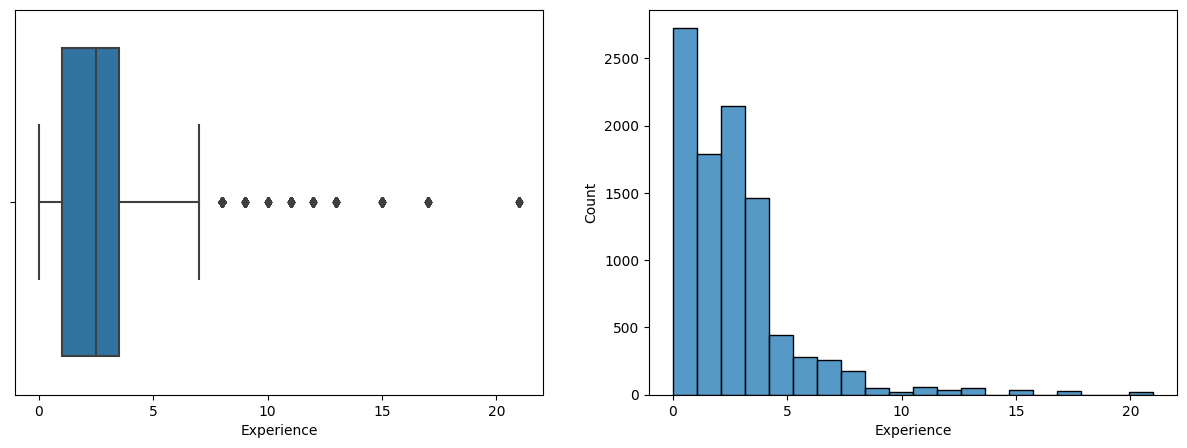

In [23]:
fig = plt.gcf()
fig.set_size_inches(15, 5)
ax = fig.add_subplot(121)
_ = sns.boxplot(data, x='Experience', ax=ax)
ax = fig.add_subplot(122)
_ = sns.histplot(data.Experience, bins=20, ax=ax)

## Preparing the `Technologies` feature for sklearn DictVectorizer

In [24]:
# lets check the unique Technologies
all_tech = '/'.join(data.Technologies)

# using the python `set` to remove duplicates
all_tech = set(map(lambda x: x.lower(), all_tech.split('/')))
len(all_tech), all_tech

(57,
 {'',
  'ai',
  'anglais',
  'aws',
  'big data',
  'c',
  'c++',
  'cassandra',
  'deep learning',
  'docker',
  'elasticsearch',
  'excel',
  'gnu',
  'hadoop',
  'hadoop(hdfs)',
  'hbase',
  'hdfs',
  'hive',
  'java',
  'kafka',
  'kibana',
  'linux',
  'machine learning',
  'map-reduce',
  'mariadb',
  'matlab',
  'matplotlib',
  'microsoft azure',
  'mongodb',
  'mysql',
  'nosq',
  'nosql',
  'numpy',
  'oracle',
  'perl',
  'pig',
  'postgresql',
  'pycharm',
  'pyspark',
  'python',
  'r',
  'redshift',
  'ruby',
  'sas',
  'scala',
  'scikit-learn',
  'scoring',
  'spark',
  'spss',
  'sql',
  'tableau',
  'tensorflow',
  'teradata',
  'vba',
  'vertica',
  'windows',
  'yarn'})

<div class="alert alert-block alert-info">
    <b>We can see issues like `nosq` and `nosql`, `''`, `hadoop`, `hadoop(hdfs)`, `hdfs`</b>
</div>

In [48]:
data['Technologies'] = data['Technologies'].str.lower()

# fixing `''`
data.loc[data['Technologies'].str.contains('//'), 'Technologies'] = data['Technologies'].str.replace('//', '/', regex=False)

# fixing `nosq`
data.loc[data['Technologies'].str.contains('/nosq/'), 'Technologies'] = data['Technologies'].str.replace('/nosq/', '/nosql/', regex=False)

In [49]:
# creating synonyms to replace

synonyms = {'hadoop(hdfs)': 'hadoop', 
            'hdfs': 'hadoop'} 

for syn, parent in synonyms.items():
    data.loc[data['Technologies'].str.contains(syn, regex=False), 'Technologies'] = data['Technologies'].str.replace(syn, parent, regex=False)

In [50]:
data['Techlist'] = data.Technologies.apply(lambda x: x.split('/'))
data.head()

,Entreprise,Metier,Technologies,Diplome,Experience,Ville,Techlist
0,Sanofi,Data scientist,matlab/python/pyspark/scikit-learn/tensorflow,Master,0.000100,Paris,"[matlab, python, pyspark, scikit-learn, tensor..."
1,Massachusetts General Hospital(MGH),Data architecte,python/java/scala/mongodb,Master,1.141996,Marseille,"[python, java, scala, mongodb]"
2,UNKNOWN,Lead data scientist,spss/sql/teradata/r/python/tensorflow/scikit-l...,Master,1.141996,Nantes,"[spss, sql, teradata, r, python, tensorflow, s..."
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,c/c++/java/python,Master,0.411343,Marseille,"[c, c++, java, python]"
4,UNKNOWN,Data scientist,matlab/python/c++/numpy/tensorflow/scikit-learn,Phd,-6.788465,Bordeaux,"[matlab, python, c++, numpy, tensorflow, sciki..."


## Training a baseline model

In [52]:
def get_confusion_matrix(clf, X_train, y_train, X_test, y_test):
    from sklearn.metrics import ConfusionMatrixDisplay
    
    
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)

    fig = plt.figure()
    fig.set_size_inches(18, 5)

    # Train 
    ax = fig.add_subplot(121)

    ConfusionMatrixDisplay.from_predictions(y_train, pred_train, ax=ax)
    ax.xaxis.set_ticklabels(data.Metier.unique(), rotation=45)
    ax.yaxis.set_ticklabels(data.Metier.unique())
    _ = ax.set_title(
        f"TrainSet Confusion Matrix Using a {clf.__class__.__name__}"
    )

    # Test
    ax = fig.add_subplot(122)

    ConfusionMatrixDisplay.from_predictions(y_test, pred_test, ax=ax)
    ax.xaxis.set_ticklabels(data.Metier.unique(), rotation=45)
    ax.yaxis.set_ticklabels(data.Metier.unique())
    _ = ax.set_title(
        f"TestSet Confusion Matrix Using a {clf.__class__.__name__}"
    )

    return fig

In [65]:
def train_baseline_model(model, X, y):


        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=121, shuffle=True)
        

        vec = DictVectorizer()
        X_train = vec.fit_transform(X_train.to_dict(orient='records'))
        X_test = vec.transform(X_test.to_dict(orient='records'))
        
        clf = model()

        clf.fit(X_train, y_train)
        pred_train = clf.predict(X_train)
        pred_test = clf.predict(X_test)
        
        print(f"{clf.__str__()[:-2]} :: Train score: {clf.score(X_train, y_train)}")
        print(f"{clf.__str__()[:-2]} :: Test score: {clf.score(X_test, y_test)}")

        get_confusion_matrix(clf, X_train, y_train, X_test, y_test).show()
        
        return clf, vec

RidgeClassifier :: Train score: 0.8751470780494183
RidgeClassifier :: Test score: 0.8745426032409828
RandomForestClassifier :: Train score: 0.9658778925349719
RandomForestClassifier :: Test score: 0.8771562990067956


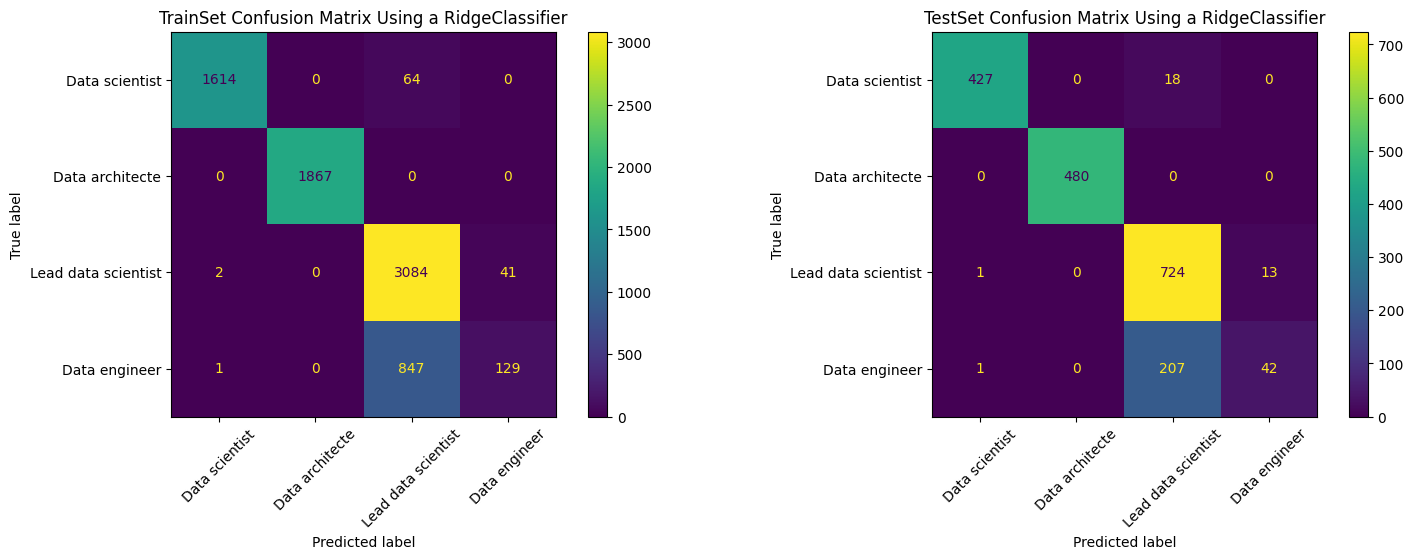

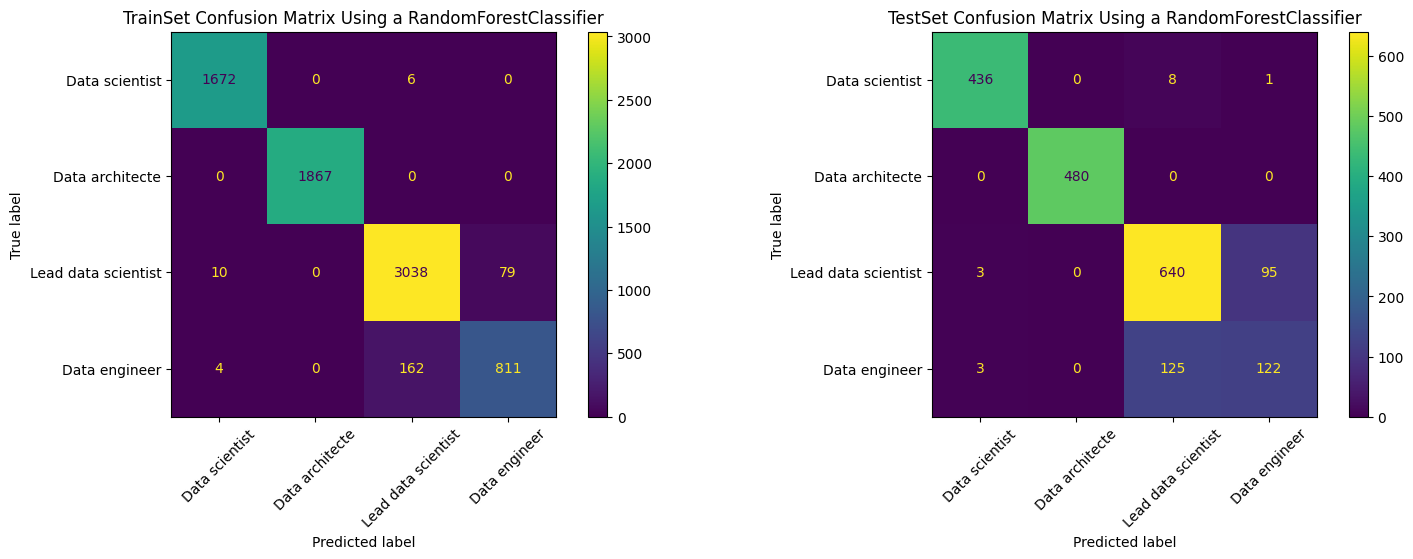

In [66]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
import mlflow

X, y = data[['Diplome', 'Ville', 'Techlist', 'Experience']].copy(), data.Metier.copy()


mlflow.set_tracking_uri('http://18.157.175.19:5000/')
mlflow.set_experiment('baseline')

models = {'ridge': RidgeClassifier, 'rf': RandomForestClassifier}
vecs = {'ridge': None, 'rf': None}

for k, v in models.items():
    models[k], vecs[k] = train_baseline_model(v, X, y)

In [80]:
from typing import List


def pred_profile(degree: str, 
                 expr: float, 
                 city: str, 
                 entrp: str, 
                 skills: List):
    
    if degree in ['PhD', 'PHD', 'Phd']:
        degree = 'Phd'
    elif degree in ['NO', 'None', 'No Degree', 'No diploma']:
        degree = 'No diploma'
    elif degree in ['MASTER', 'MSc', 'Mastere', 'msc', 'master', 'Master']:
        degree = 'Master'
    elif degree in ['Bachelor', 'bachelor', 'BSc']:
        degree = 'Bachelor'
    
    city = city.capitalize()
    
    skills = list(map(lambda x: x.lower(), skills))
    
    x = {'Diplome': degree, 'Ville': city, 
                      'Techlist': skills, 'Experience': expr}
    x = vecs['rf'].transform(x)
    
    return models['rf'].predict(x)

## Sample Predictions

In [81]:
"""
Thierry, PhD, 4 years of experience, living in Marseille and working for Symantec, who is skilled in Python,
Tensorflow, scikit-learn, deep learning and R.
- Salomé, working for Jacobs since 2,5 years with proficiency in Python, Spark, GNU and Linux.
- Yannick from Ball Aerospace. He has a Master degree and 15 years of experience, and is experienced in
VBA, Python, Excel and R.
- Jason, living in Toulouse and working for eHire LLC for 1,5 year after his Master. He is skilled in Java, C, C++,
R and Python
- Kevin from Bordeaux, working with Map-Reduce/HDFS/PIG/HBASE/Python/Cassandra. He has some years
of experience and holds a Master degree
"""

'\nThierry, PhD, 4 years of experience, living in Marseille and working for Symantec, who is skilled in Python,\nTensorflow, scikit-learn, deep learning and R.\n- Salomé, working for Jacobs since 2,5 years with proficiency in Python, Spark, GNU and Linux.\n- Yannick from Ball Aerospace. He has a Master degree and 15 years of experience, and is experienced in\nVBA, Python, Excel and R.\n- Jason, living in Toulouse and working for eHire LLC for 1,5 year after his Master. He is skilled in Java, C, C++,\nR and Python\n- Kevin from Bordeaux, working with Map-Reduce/HDFS/PIG/HBASE/Python/Cassandra. He has some years\nof experience and holds a Master degree\n'

In [83]:
# Thierry
pred_profile('Phd', expr=4, city='Paris', entrp='Symantec', 
             skills=['Python', 'Tensorflow', 'scikit-learn', 'deep learning', 'R'])

array(['Data scientist'], dtype=object)

In [84]:
# Salome
pred_profile('None', expr=2.5, city='Paris', entrp='Jacobs', 
             skills=['Python', 'Spark', 'GNU', 'Linux'])

array(['Data engineer'], dtype=object)

In [85]:
# Yannick
pred_profile('Master', expr=15, city='Paris', entrp='Ball Aerospace', 
             skills=['Python', 'VBA', 'Excel', 'R'])

array(['Lead data scientist'], dtype=object)

In [88]:
# Jason
pred_profile('Master', expr=1.5, city='Toulouse', entrp='eHire LLC', 
             skills=['Java', 'C', 'C++', 'R', 'Python'])

array(['Lead data scientist'], dtype=object)

In [87]:
# Kevin
pred_profile('Master', expr=2, city='Bordeaux', entrp='UNKNOWN', 
             skills=['Map-Reduce', 'HDFS', 'PIG', 'HBASE', 'Python', 'Cassandra'])

array(['Data engineer'], dtype=object)